# Goodreads Data User #2 Analysis

## Initial Data Exploration

In [49]:
#Ignore deprecated warning buried in 3rd party packages
#(comment initially to look at warning and suppress warnings later)
import warnings
warnings.filterwarnings('ignore')

#Import useful libraries and open the file
import pandas as pd #dataframe organization
import os
import numpy as np
import seaborn as sns #stats plotting toolbox
from scipy import stats
import matplotlib.pyplot as plt #plotting
import util #my library with some useful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score #classifier performance
from sklearn.metrics import recall_score #classifier performance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV, calibration_curve #classifier calibration
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import KFold
import requests


#Read in a user's file
test_df = pd.read_csv("../input/goodreads_library_export_user2.csv", encoding = "ISO-8859-1")

print('Lookign at the first few rows: ')
test_df.head()



Lookign at the first few rows: 


,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Private Notes,Read Count,Recommended For,Recommended By,Owned Copies,Original Purchase Date,Original Purchase Location,Condition,Condition Description,BCID
0,13581476,FLCL Omnibus,Gainax,"Gainax, Gainax",Hajime Ueda,1595828680,9.781596e+12,0,3.88,Dark Horse Comics,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,34128219,"La Belle Sauvage (The Book of Dust, #1)",Philip Pullman,"Pullman, Philip",NaN,0375815309,9.780376e+12,4,4.20,Alfred A. Knopf,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,4025275,War's Unwomanly Face,Svetlana Alexievich,"Alexievich, Svetlana",NaN,5010004941,9.785010e+12,5,4.52,Progress Publishers,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,36521370,Cherry,Nico Walker,"Walker, Nico",NaN,178733094X,9.781787e+12,0,4.02,Jonathan Cape,...,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,15177,Bridge of Birds (The Chronicles of Master Li a...,Barry Hughart,"Hughart, Barry",NaN,0345321383,9.780345e+12,0,4.29,Del Rey,...,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [2]:
#Understand how many data points and what is potentially contained within each point

print('Number of data total data points: ', test_df.shape[0])
print('Number of features for each data point: ', test_df.shape[1])
print('')
print('A list of all columns: ')
print(test_df.columns)

Number of data total data points:  570
Number of features for each data point:  31

A list of all columns: 
Index(['Book Id', 'Title', 'Author', 'Author l-f', 'Additional Authors',
       'ISBN', 'ISBN13', 'My Rating', 'Average Rating', 'Publisher', 'Binding',
       'Number of Pages', 'Year Published', 'Original Publication Year',
       'Date Read', 'Date Added', 'Bookshelves', 'Bookshelves with positions',
       'Exclusive Shelf', 'My Review', 'Spoiler', 'Private Notes',
       'Read Count', 'Recommended For', 'Recommended By', 'Owned Copies',
       'Original Purchase Date', 'Original Purchase Location', 'Condition',
       'Condition Description', 'BCID'],
      dtype='object')


In [3]:
#Remove all entries w/ "0" in the "My Rating" field, these haven't been read/reviewed
test_df.drop(test_df.loc[test_df['My Rating'] == 0].index, inplace=True)

#Now, look at the new size of the dataset
print('Number of data total data points: ', test_df.shape[0])


Number of data total data points:  378


In [4]:
#Data looks pretty sparse. Show a histogram of the number of populated features

#Replace all '0' wth null, they are the same here
test_df.replace(to_replace=0, value=np.nan , inplace=True)
test_df.head()

percent_filled_cells = pd.DataFrame((test_df.notna().sum()/test_df.shape[0]*100), columns=['Data Present (%)'])

percent_filled_cells.style.bar(color=['#5fba7d'])

#Data cleaning - All entries whose fields contain 0% are eliminated
test_df.drop(columns=percent_filled_cells.loc[percent_filled_cells['Data Present (%)'] < 1].index, inplace=True)

percent_filled_cells_edited = pd.DataFrame((test_df.notna().sum()/test_df.shape[0]*100), columns=['Data Present (%)'])

percent_filled_cells.style.bar(color=['#5fba7d'])



,Data Present (%)
Book Id,100
Title,100
Author,100
Author l-f,100
Additional Authors,40.2116
ISBN,96.5608
ISBN13,96.8254
My Rating,100
Average Rating,100
Publisher,98.9418


### Misc Data Distribution


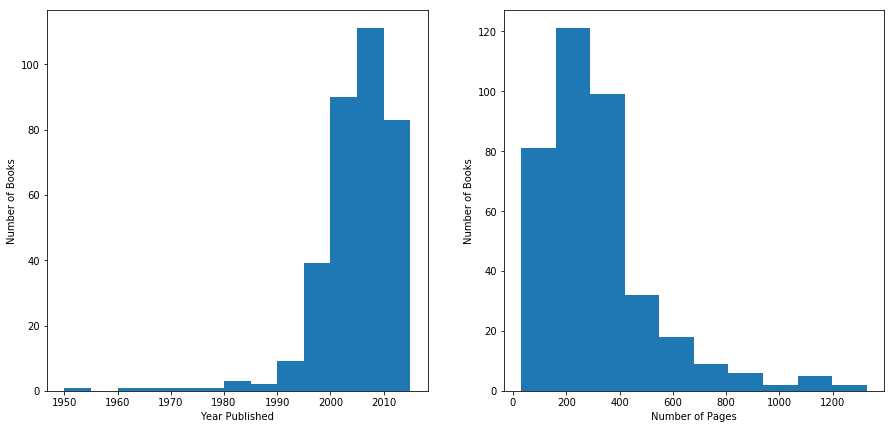

In [5]:
#Let's look at some at teh various statistucs about the books

#When are the books published

plt.figure(1, figsize=(15, 7))
plt.subplot(121)
plt.hist(test_df['Year Published'], bins=np.arange(test_df['Year Published'].min(), test_df['Year Published'].max(), 5))
plt.xlabel('Year Published')
plt.ylabel('Number of Books')

plt.subplot(122)
plt.hist(test_df.loc[test_df['Number of Pages'].notna()]['Number of Pages'])
plt.xlabel('Number of Pages')
plt.ylabel('Number of Books')


plt.show()


In [6]:
#Categorize the authors so it's easier to group them 
labels, uniques = pd.factorize(test_df['Author'])

#Find the number of books read for each author
author_count, author_index = np.histogram(labels, bins = range(uniques.size+1))
#Add the author count to our originial datframe for later use
test_df['Number of Books Read by this Author']=pd.Series(labels, index=test_df.index).map(lambda x: author_count[x])
#Create a histogram for authors: number of books read
author_freq, num_books = np.histogram(author_count, bins = range(1,26))

#Create a dataframe with only hist bins that were populated
df_author_info = pd.DataFrame(data={'Number of Books': num_books[:-1], 'Author Frequency': author_freq})
df_author_info.drop(df_author_info.loc[df_author_info['Author Frequency'] == 0].index, inplace=True)
df_author_info.set_index('Number of Books', inplace=True)

#Show the author information
df_author_info.style.bar(color='orange')


#print('Number of different authors of books rated present in the dataset:', factorized_authors[1].size)

,Author Frequency
Number of Books,
1,119
2,9
3,15
4,8
5,4
6,1
7,1
8,2
9,1


### Ratings Data

The following analysis investigates general trends regarding the books' ratings. Goodreads users rate books on a scale from 1-5 with increments of 1 (i.e., 1, 2, 3, 4, 5).

First, the mean ratings for all books read by this user is shown. The ratings distribution appear to be Gaussian in nature with $\mu=4.10$ and $\sigma=0.25$. A Chi-squared test was performed to evaluate the goodness of fit of the Gaussian curve on the global ratings distribution data. The test yielded the following values: $\chi^{2}=21.40$ and $p=0.9997$. In other words, the probability that our null hypothesis that this Gaussian function is a good fit for our data is correct is 99.97%. In layman terms, it seems to be a very good fit.

In the same vein, we look at this particular users' ratings. Because the user is limited to only 5 different ratings (1,2,..5), the histogram takes on a more discretized appearance. A discussion with the user revealed that she tends to select books that she believes she will like, leading to the skew toward higher ratings. Again I tried to fit a Gaussian curve on the user's data. The Gaussian parameters were calculated as: $\mu=4.42$ and $\sigma=0.59$. A Chi-squared test was performed to evaluate the goodness of fit of the Gaussian curve on the user's ratings distribution data. The test yielded the following values: $\chi^{2}=22.41$ and $p=0$. In other words, the probability that our null hypothesis that this Gaussian function is a good fit for our data is correct is ~0%. In layman terms, the Gaussian curve is a very bad fit for the user data. This is not surprising as there are too few bins (i.e. degrees of freedom in the Chi-squared test) to fit a Gaussian curve to the data with any statistical significance.



Chi Squared Test for global ratings of books
Probability that the null hypothesis stating that global ratings are normally distributed: 0.999757
Gaussian fit parameters: mean=4.103, standard deviation=0.2548

Chi Squared Test for one user's ratings of books
Probability that the null hypothesis stating that global ratings are normally distributed: 5.34449e-05
Gaussian fit parameters: mean=4.423, standard deviation=0.5871


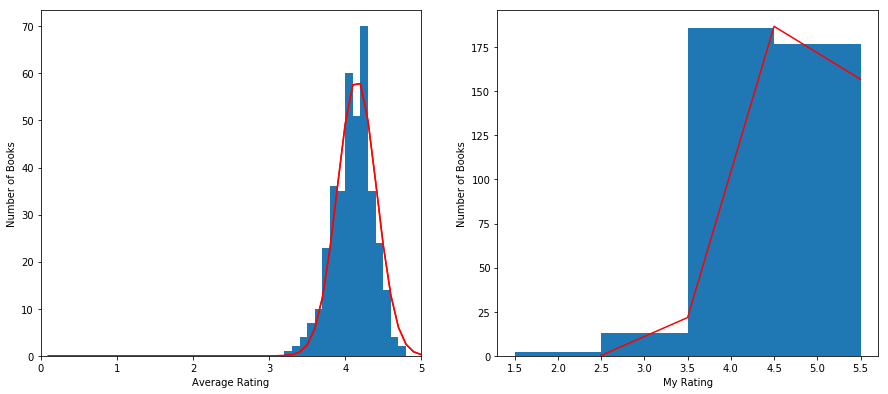

In [7]:
#Global and User ratings distributions

#Universal average ratings of the books
plt.figure(1, figsize=(15, 14))
plt.subplot(221)

num_points = test_df['Average Rating'].shape[0]
#Plot the histogram
hist_bins = np.arange(0, 5.1, 0.1)
actual_count, actual_bins, ignored = plt.hist(test_df['Average Rating'], bins = hist_bins)
#Find a guassian fit to the distribution curve
param = stats.norm.fit(test_df['Average Rating'])
gprob = np.diff(stats.norm.cdf(actual_bins, loc=param[0], scale=param[1]))
plt.plot(actual_bins[1:],gprob*num_points, 'r-')
plt.xlim(0,5)
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')

#Performing a chi-squared test to see if the guassian fit is good
gprob = np.diff(stats.norm.cdf(actual_bins, loc=param[0], scale=param[1]))
plt.plot(actual_bins[1:],gprob*num_points, 'r-')
nch, npval = stats.chisquare(actual_count, gprob*num_points)
print('Chi Squared Test for global ratings of books')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param[0], param[1]))
print('')

#My ratings of books
plt.subplot(222)
my_bins = np.arange(1.5, 6.5, 1)
actual_count_user, my_bins, ignored = plt.hist(test_df['My Rating'], bins=my_bins)
plt.xlabel('My Rating')
plt.ylabel('Number of Books')

#Find a guassian fit on the user's ratings
param_user = stats.norm.fit(test_df['My Rating'])
gprob_user = np.diff(stats.norm.cdf(my_bins, loc=param_user[0], scale=param_user[1]))
plt.plot(my_bins[1:],gprob_user*num_points, 'r-')
#Perform a chi squared test to detemine goodness of fit of guassian on user's ratings
nch_user, npval_user = stats.chisquare(actual_count_user, gprob_user*num_points)
print('Chi Squared Test for one user\'s ratings of books')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval_user) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_user[0], param_user[1]))


## Optimizing Book Selection

Ultimately the goal of this model is to optimize book selection. If we could build a model that accurately predicts a user's rating, then the model could be used to make book recommendations to our reader.

The first and most obvious way to recommend books to the reader is by choosing books with high global ratings. Consequently, the analysis presented here first explores the relationship between the global ratings of a book and the user's ratings.

Next, I investigated the use of classifiers to predict whether or not the user would rate the book as a '5'. Two different types of classifiers were explored here: random forest classifier and naiive bayes classifier. This analysis looks at different feature selection and classifier calibration as a way to improve performance. Cross validation analysis is also performed to give more accurate model prediction performance.

### User Rating vs. Global Rating

Intuition leads us to the following hypothesis: there is a positive relationship between a book's global ratings and a user's ratings.

We first look at the joint distribution between these two variables. In general, the joint distribution seems to confirm our hypothesis. The books with User Rating of '5' were more likely to have a higher global rating when compared to books with a User Rating of '4'.

To make this observation a little clearer, I show the conditional probability distribution functions. For both, a Gaussian curve was fitted to the distributions. The null hypothesis that the fitted curve is a good fit for the distributions is accepted with a probability > 99.99% for both. For books that received a user rating of 5, the global ratings had the following properties: $\mu=4.21$ and $\sigma=0.22$. Likewise, for books that received a user rating of 5, the global ratings had the following properties: $\mu=4.04$ and $\sigma=0.24$. The conclusions drawn from this analysis is that there is a clear trend between global ratings and this particular user's ratings.


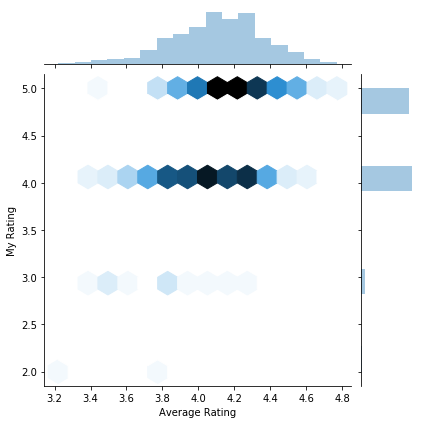

In [8]:
#Create a series with the differece between the ratings
diff_ratings = test_df['Average Rating']-test_df['My Rating']

# diff_hist_bins = np.arange(-3, 3, 0.1)
# plt.hist(diff_ratings, bins=diff_hist_bins)
# plt.xlabel('Average Rating - My Rating')
# plt.ylabel('Number of Books')

# plt.show()

#Show the joint distribution of average rating and user rating
sns.jointplot(x='Average Rating', y='My Rating', data=test_df, kind="hex")
plt.show()


Chi Squared Test for User Rating = 5
Probability that the null hypothesis stating that global ratings are normally distributed: 0.999977
Gaussian fit parameters: mean=4.205, standard deviation=0.2158

Chi Squared Test for User Rating = 4
Probability that the null hypothesis stating that global ratings are normally distributed: 0.999949
Gaussian fit parameters: mean=4.035, standard deviation=0.2372


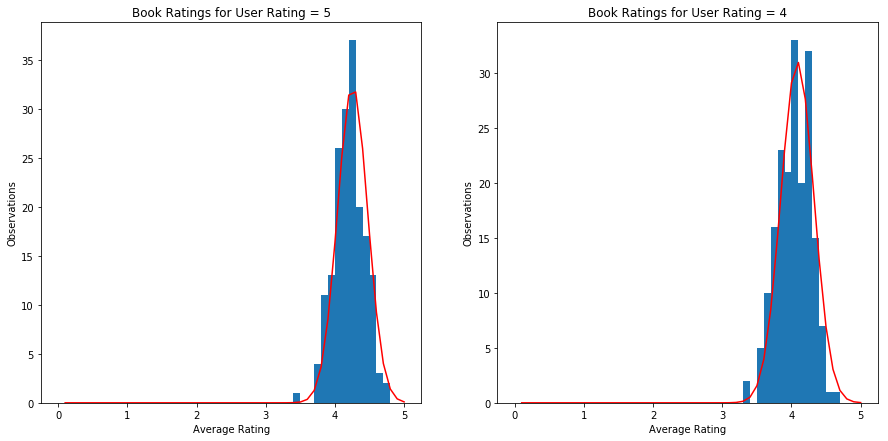

In [9]:
#Show the condition probablilities of global ratings given the user ratings

#Show the histogram of global ratings for user rating = 5
plt.figure(1, figsize=(15, 7))
plt.subplot(121)
plt.xlabel('Average Rating')
plt.ylabel('Observations')
plt.title('Book Ratings for User Rating = 5')
#Define the hist bins
hist_bins = np.arange(0, 5.1, 0.1)
#Define a series of average ratings where user rated as '5'
cond_ratings_5 = test_df.loc[test_df['My Rating'] == 5]['Average Rating']
#Fit a guassian curve and plot histogram and fitted curve
actual_count, actual_bins, param_mean_5, param_std_5, nch_5, npval_5 = util.guass_fit_dist(cond_ratings_5, hist_bins = hist_bins)
#Print guassian params and goodness of fit test results
print('Chi Squared Test for User Rating = 5')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval_5) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_mean_5, param_std_5))
print('')

#Show the histogram of global ratings for user rating = 4
plt.subplot(122)
plt.xlabel('Average Rating')
plt.ylabel('Observations')
plt.title('Book Ratings for User Rating = 4')
#Define a series of average ratings where user rated as '4'
cond_ratings_4 = test_df.loc[test_df['My Rating'] == 4]['Average Rating']
#Fit a guassian curve
actual_count, actual_bins, param_mean_4, param_std_4, nch_4, npval_4 = util.guass_fit_dist(cond_ratings_4, hist_bins = hist_bins)
#Print guassian params and goodness of fit test results
print('Chi Squared Test for User Rating = 4')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval_4) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_mean_4, param_std_4))

### Classification using Global Rating Feature Only

Here, I investigate the use of a classifier to make suggestions to the user. The classifier is a binary classifier and will predict if the user's rating is either '5' or less than '5'. The idea is that reading a book is a large time investment and the user may only want to find books he/she really enjoys. To this end, there are two important performance metrics in this project: accuracy and precision. Accuracy give a general overall sense for how well the model performs. Maximizing precision allows us to optimize for avoiding books that were not considered amazing reading material. (Alternatively, if the user was very concerned that the model would mi

At this stage in the analysis, the classifier only incorporates one feature input: book's global average rating. In this section, the training and test datasets will be the same across classifiers. The training and test data was split 75%/25% at random. 


#### Random Forest Classifier w/ Global Feature Only

First I implemented a random forest classifier. Prior to extensive calibration of the classifier, the accuracy of the classifier is approximately 69%. In other words, the classifier build can accurately predict whether a user will assign a '5' 69% of the time. The classifier's precision is 58% and the recall is 29%. 

In [112]:
#Build a random forest classifier to find books' ratings

#Split the data into train/test data
x_train, x_test, y_train, y_test = train_test_split(np.array(test_df['Average Rating']).reshape(-1, 1), np.array(test_df['My Rating']==5).reshape(-1, 1), test_size=0.25, random_state=0)
#Build decision tree
model = RandomForestClassifier(random_state=1)
model.fit(x_train, y_train)

print('Random Forest Classifier Performance')
ignore = util.print_classifier_metrics(model, x_test, y_test)

Random Forest Classifier Performance
Accuracy of model: 0.69
Recall Score: 0.29
Precision Score: 0.58


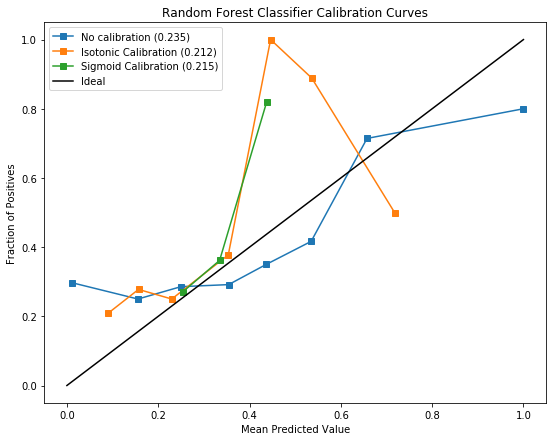

Isotonic Calibrated Random Forest Classifier Performance
Accuracy of model: 0.71
Recall Score: 0.18
Precision Score: 0.82

Sigmoid Calibrated Random Forest Classifier Performance
Accuracy of model: 0.66
Recall Score: 0.0
Precision Score: 0.0


In [113]:
plt.figure(1, figsize=(9, 7))
plt.title('Random Forest Classifier Calibration Curves')
model_iso, model_sig = util.pro_class_calibration(model, x_train, y_train, x_test, y_test)

print('Isotonic Calibrated Random Forest Classifier Performance')
ignore = util.print_classifier_metrics(model_iso, x_test, y_test)
print('')
print('Sigmoid Calibrated Random Forest Classifier Performance')
ignore = util.print_classifier_metrics(model_sig, x_test, y_test)



#### Naiive Bayes Classifier w/ Global Rating Feature Only

Prior to extensive calibration of the classifier, the accuracy of the classifier is approximately 71%. In other words, the classifier build can accurately predict whether a user will assign a '5' 71% of the time. The classifier's precision is 82% and the recall is 18%.

In [114]:
#Build a naiive bayes classifier to find books' ratings

model_bayes = GaussianNB()
model_bayes.fit(x_train, y_train)

print('Naiive Bayes Classifier Performance')
ignore = util.print_classifier_metrics(model_bayes, x_test, y_test)

Naiive Bayes Classifier Performance
Accuracy of model: 0.71
Recall Score: 0.18
Precision Score: 0.82


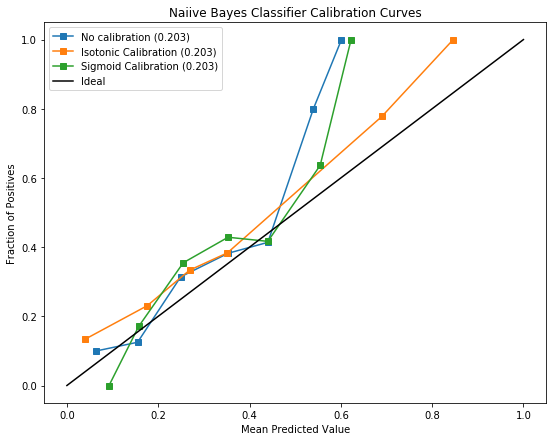

In [115]:
#Look at calibration of naiive bayes classifier
plt.figure(1, figsize=(9, 7))
plt.title('Naiive Bayes Classifier Calibration Curves')
model_iso, model_sig = util.pro_class_calibration(model_bayes, x_train, y_train, x_test, y_test)


#### Cross-Validation of Classifiers w/ Global Rating Feature Only




In [111]:
#Look at how cross validation changes the performance of both types of classifiers
#Split the data into train/test data k-times

#define total feature and prediction matrices
x_all = np.array(test_df['Average Rating']).reshape(-1, 1)
y_all = np.array(test_df['My Rating']==5).reshape(-1, 1)

#instantiate a k-fold object
kf = KFold(n_splits=10, shuffle=True, random_state=29)
#create a matrix to store score values
random_forest_scores = []
bayes_scores = []

#iterate through the 10 folds and calculate the acuuracy for each
for train_index, test_index in kf.split(x_all):
    #Define the train and test data for this iteration
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    #Build a random forest classifier and record the score
    model = RandomForestClassifier(random_state=1)
    model.fit(x_train, y_train)
    random_forest_scores.append(model.score(x_test, y_test))
    
    #Build a bayes classifier and record the score
    model2 = GaussianNB()
    model2.fit(x_train, y_train)
    bayes_scores.append(model2.score(x_test, y_test))
    
print('Random Forest Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(random_forest_scores), np.std(random_forest_scores)))
print('Naiive Bayes Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(bayes_scores), np.std(bayes_scores)))



Random Forest Accuracy: mean=0.69, standard deviation=0.032
Naiive Bayes Accuracy: mean=0.72, standard deviation=0.037


### Expanding features


In [14]:
#Investigate relationship between # of books read by an author and user's ratings
#Hypothesis: There is a positive relationship between number of books read by an author and rating

#Look at correlation coefficients between author count and ratings
test_df[['Average Rating', 'My Rating', 'Number of Pages', 'Year Published', 'Original Publication Year', 'Number of Books Read by this Author']].corr()

# #plt.scatter(test_df['Number of Books Read by this Author'], test_df['My Rating'])
# # sns.jointplot(x='Number of Books Read by this Author', y='My Rating', data=test_df, kind="hex", marginal_kws=dict(bins=5))
# # plt.show()

# plt.hist(test_df.loc[test_df['My Rating'] == 5]['Number of Books Read by this Author'])
# plt.show()

,Average Rating,My Rating,Number of Pages,Year Published,Original Publication Year,Number of Books Read by this Author
Average Rating,1.000000,0.435492,0.177515,0.009264,0.164261,0.205566
My Rating,0.435492,1.000000,0.153764,-0.151078,0.103158,0.161311
Number of Pages,0.177515,0.153764,1.000000,-0.054047,0.070081,-0.075529
Year Published,0.009264,-0.151078,-0.054047,1.000000,0.108626,0.053698
Original Publication Year,0.164261,0.103158,0.070081,0.108626,1.000000,0.093095
Number of Books Read by this Author,0.205566,0.161311,-0.075529,0.053698,0.093095,1.000000


In [44]:
#Construct a new Bayes classifier with 2 features

features = np.append(np.array(test_df['Average Rating']).reshape(-1, 1), np.array(test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(features, np.array(test_df['My Rating']==5).reshape(-1, 1), test_size=0.25, random_state=0)


model_bayes2 = GaussianNB()
model_bayes2.fit(x_train2, y_train2)
y_hat2 = model_bayes2.predict(x_test2)
print('Accuracy of model: {:.2}'.format(model_bayes2.score(x_test2, y_test2)))
print('Recall Score: {:.2}'.format(recall_score(y_test2,y_hat2)))
print('Precision Score: {:.2}'.format(precision_score(y_test2,y_hat2)))


Accuracy of model: 0.69
Recall Score: 0.71
Precision Score: 0.64


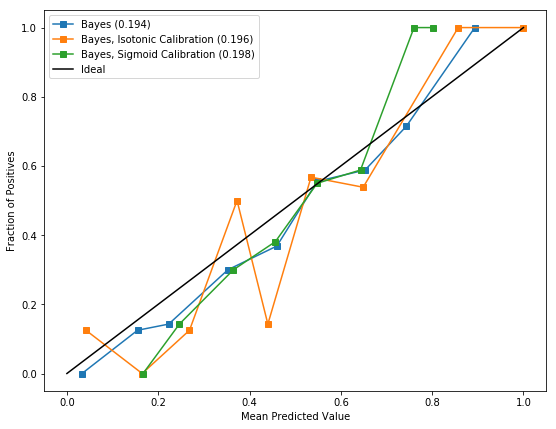

Accuracy of model: 0.71
Recall Score: 0.86
Precision Score: 0.62


In [45]:
#Look at calibration of naiive bayes classifier

#Find the P(y=1) according to the classifier
prob_pos_bayes2 = model_bayes2.predict_proba(x_test2)[:, 1]
#Find the brier score (a way of comparing probabilistic classifiers)
bayes_score2 = brier_score_loss(y_test2, prob_pos_bayes2)

# Gaussian Naive-Bayes with isotonic calibration
bayes_isotonic2 = CalibratedClassifierCV(model_bayes2, cv=2, method='isotonic')
bayes_isotonic2.fit(x_train2, y_train2)
prob_pos_isotonic2 = bayes_isotonic2.predict_proba(x_test2)[:, 1]
iso_score2 = brier_score_loss(y_test2, prob_pos_isotonic2)

# Gaussian Naive-Bayes with sigmoid calibration
bayes_sigmoid2 = CalibratedClassifierCV(model_bayes2, cv=2, method='sigmoid')
bayes_sigmoid2.fit(x_train2, y_train2)
prob_pos_sigmoid2 = bayes_sigmoid2.predict_proba(x_test2)[:, 1]
sig_score2 = brier_score_loss(y_test2, prob_pos_sigmoid2)


#Find the calibration curve values
fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_test2, prob_pos_bayes2, n_bins=10)
fraction_of_positives_iso2, mean_predicted_value_iso2 = calibration_curve(y_test2, prob_pos_isotonic2, n_bins=10)
fraction_of_positives_sig2, mean_predicted_value_sig2 = calibration_curve(y_test2, prob_pos_sigmoid2, n_bins=10)


#Plot the calibration curves
plt.figure(1, figsize=(9, 7))
plt.plot(mean_predicted_value2, fraction_of_positives2, "s-", label="%s (%1.3f)" % ('Bayes', bayes_score2))
plt.plot(mean_predicted_value_iso2, fraction_of_positives_iso2, "s-", label="%s (%1.3f)" % ('Bayes, Isotonic Calibration', iso_score2))
plt.plot(mean_predicted_value_sig2, fraction_of_positives_sig2, "s-", label="%s (%1.3f)" % ('Bayes, Sigmoid Calibration', sig_score2))
#Plot the ideal line
plt.plot([0, 1], [0, 1], "k", label = 'Ideal')
#Show legend, axes, etc formatting
plt.legend(loc="best")
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.show()

y_hat2 = bayes_isotonic2.predict(x_test2)
print('Accuracy of model: {:.2}'.format(bayes_isotonic2.score(x_test2, y_test2)))
print('Recall Score: {:.2}'.format(recall_score(y_test2,y_hat2)))
print('Precision Score: {:.2}'.format(precision_score(y_test2,y_hat2)))

In [46]:
#Construct a new Bayes classifier with 4 features

new_features = ['Number of Pages', 'Year Published']

pruned_test_df = test_df.copy()
for feat in new_features:
    pruned_test_df.drop(pruned_test_df.loc[pruned_test_df[feat].isna()].index, inplace=True)
    

features4 = np.append(np.array(pruned_test_df['Average Rating']).reshape(-1, 1), np.array(pruned_test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
for feat in new_features:
    features4 = np.append(features4, np.array(pruned_test_df[feat]).reshape(-1, 1), axis=1)



x_train4, x_test4, y_train4, y_test4 = train_test_split(features4, np.array(pruned_test_df['My Rating']==5).reshape(-1, 1), test_size=0.25, random_state=1)


model_bayes4 = GaussianNB()
model_bayes4.fit(x_train4, y_train4)
y_hat4 = model_bayes4.predict(x_test4)
print('Accuracy of model: {:.2}'.format(model_bayes4.score(x_test4, y_test4)))
print('Recall Score: {:.2}'.format(recall_score(y_test4,y_hat4)))
print('Precision Score: {:.2}'.format(precision_score(y_test4,y_hat4)))


Accuracy of model: 0.64
Recall Score: 0.47
Precision Score: 0.74


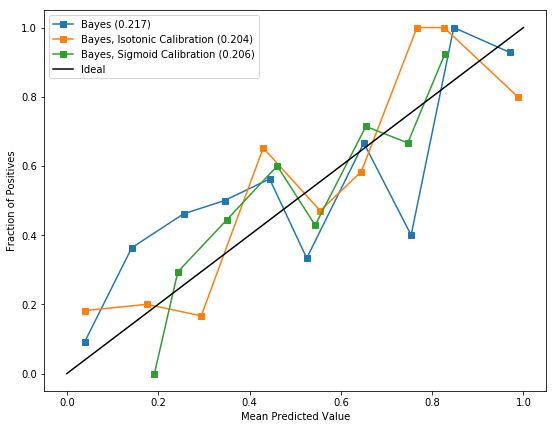

Accuracy of model: 0.63
Recall Score: 0.59
Precision Score: 0.66


In [47]:
#Look at calibration of naiive bayes classifier

#Find the P(y=1) according to the classifier
prob_pos_bayes4 = model_bayes4.predict_proba(x_test4)[:, 1]
#Find the brier score (a way of comparing probabilistic classifiers)
bayes_score4 = brier_score_loss(y_test4, prob_pos_bayes4)

# Gaussian Naive-Bayes with isotonic calibration
bayes_isotonic4 = CalibratedClassifierCV(model_bayes4, cv=2, method='isotonic')
bayes_isotonic4.fit(x_train4, y_train4)
prob_pos_isotonic4 = bayes_isotonic4.predict_proba(x_test4)[:, 1]
iso_score4 = brier_score_loss(y_test4, prob_pos_isotonic4)

# Gaussian Naive-Bayes with sigmoid calibration
bayes_sigmoid4 = CalibratedClassifierCV(model_bayes4, cv=2, method='sigmoid')
bayes_sigmoid4.fit(x_train4, y_train4)
prob_pos_sigmoid4 = bayes_sigmoid4.predict_proba(x_test4)[:, 1]
sig_score4 = brier_score_loss(y_test4, prob_pos_sigmoid4)


#Find the calibration curve values
fraction_of_positives4, mean_predicted_value4 = calibration_curve(y_test4, prob_pos_bayes4, n_bins=10)
fraction_of_positives_iso4, mean_predicted_value_iso4 = calibration_curve(y_test4, prob_pos_isotonic4, n_bins=10)
fraction_of_positives_sig4, mean_predicted_value_sig4 = calibration_curve(y_test4, prob_pos_sigmoid4, n_bins=10)


#Plot the calibration curves
plt.figure(1, figsize=(9, 7))
plt.plot(mean_predicted_value4, fraction_of_positives4, "s-", label="%s (%1.3f)" % ('Bayes', bayes_score4))
plt.plot(mean_predicted_value_iso4, fraction_of_positives_iso4, "s-", label="%s (%1.3f)" % ('Bayes, Isotonic Calibration', iso_score4))
plt.plot(mean_predicted_value_sig4, fraction_of_positives_sig4, "s-", label="%s (%1.3f)" % ('Bayes, Sigmoid Calibration', sig_score4))
#Plot the ideal line
plt.plot([0, 1], [0, 1], "k", label = 'Ideal')
#Show legend, axes, etc formatting
plt.legend(loc="best")
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.show()

y_hat4 = bayes_isotonic4.predict(x_test4)
print('Accuracy of model: {:.2}'.format(bayes_isotonic4.score(x_test4, y_test4)))
print('Recall Score: {:.2}'.format(recall_score(y_test4,y_hat4)))
print('Precision Score: {:.2}'.format(precision_score(y_test4,y_hat4)))

In [97]:
#Look at how cross validation changes the performance of bayes w/ 2 and 4 features
#Split the data into train/test data k-times

#define total feature and prediction matrices
x2_all = np.append(np.array(pruned_test_df['Average Rating']).reshape(-1, 1), np.array(pruned_test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
x4_all = features4
y_all = np.array(pruned_test_df['My Rating']==5).reshape(-1, 1)

#instantiate a k-fold object
kf = KFold(n_splits=10, shuffle=True, random_state=2)
#create a matrix to store score values
bayes2_scores = []
bayes4_scores = []

#iterate through the 10 folds and calculate the acuuracy for each
for train_index, test_index in kf.split(x2_all):
    #Define the train and test data for this iteration
    x2_train, x2_test = x2_all[train_index], x2_all[test_index]
    x4_train, x4_test = x4_all[train_index], x4_all[test_index]    
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    #Build a 2-feature bayes classifier and record the score
    bayes2 = GaussianNB()
    bayes2.fit(x2_train, y_train)
    bayes2_scores.append(bayes2.score(x2_test, y_test))
    
    #Build a 4-feature bayes classifier and record the score
    bayes4 = GaussianNB()
    bayes4.fit(x4_train, y_train)
    bayes4_scores.append(bayes4.score(x4_test, y_test))
    
print('2-Feature Naiive Bayes Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(bayes2_scores), np.std(bayes2_scores)))
print('4-Feature Naiive Bayes Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(bayes4_scores), np.std(bayes4_scores)))



2-Feature Naiive Bayes Accuracy: mean=0.63, standard deviation=0.093
4-Feature Naiive Bayes Accuracy: mean=0.66, standard deviation=0.09


In [94]:
#Look at how cross validation changes the performance of bayes w/ 2 and 4 features
#Split the data into train/test data k-times

#define total feature and prediction matrices
x2_all = np.append(np.array(pruned_test_df['Average Rating']).reshape(-1, 1), np.array(pruned_test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
x4_all = features4
y_all = np.array(pruned_test_df['My Rating']==5).reshape(-1, 1)

#instantiate a k-fold object
kf = KFold(n_splits=10, shuffle=True, random_state=2)
#create a matrix to store score values
bayes2_scores = []
bayes4_scores = []

#iterate through the 10 folds and calculate the acuuracy for each
for train_index, test_index in kf.split(x2_all):
    #Define the train and test data for this iteration
    x2_train, x2_test = x2_all[train_index], x2_all[test_index]
    x4_train, x4_test = x4_all[train_index], x4_all[test_index]    
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    #Build a 2-feature bayes classifier and record the score
    bayes2 = RandomForestClassifier(random_state=33)
    bayes2.fit(x2_train, y_train)
    bayes2_scores.append(bayes2.score(x2_test, y_test))
    
    #Build a 4-feature bayes classifier and record the score
    bayes4 = RandomForestClassifier(random_state=33)
    bayes4.fit(x4_train, y_train)
    bayes4_scores.append(bayes4.score(x4_test, y_test))
    
print('2-Feature Naiive Bayes Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(bayes2_scores), np.std(bayes2_scores)))
print('4-Feature Naiive Bayes Accuracy: mean={:.2}, standard deviation={:.2}'.format(np.mean(bayes4_scores), np.std(bayes4_scores)))



2-Feature Naiive Bayes Accuracy: mean=0.6, standard deviation=0.054
4-Feature Naiive Bayes Accuracy: mean=0.7, standard deviation=0.084
